In [4]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3423210 sha256=488a154c83d863d33614a955e2798ed0a706b426b60d632fe8b578344a3137bb
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k


from tqdm import tqdm


import seaborn as sns

In [6]:
# data = pd.read_csv('data/retail_train.csv')
# data.head(2)

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = '/content/drive/MyDrive/Move_to/GEEK_brain/Рекомендательные системы/webinar_2/'

else:

  PATH = 'D:/'

try:
  data = pd.read_csv('../data/retail_train.csv')
except:
  data = pd.read_csv(PATH + 'retail_train.csv')

data.head(2)

Mounted at /content/drive


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [ ]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

Не очень понятно как учесть отрицательные значения логарифма и чтобы в сумме веса были равны 1. Знаю в кроссэнтропилос используют e, но будет ли это логарифмической закономерностью не уверен. В общем сделал по босяцки

In [8]:
# убрал отрицательное сдвинув вправо

if min(data['sales_value']) < 1:
  data['log_sales_value'] = np.log(data['sales_value'] - min(data['sales_value']) + 1)

else:

  data['log_sales_value'] = np.log(data['sales_value'])  

,weight
count,2.396804e+06
mean,4.172223e-07
std,1.913998e-07
min,0.000000e+00
25%,2.848617e-07
50%,3.777103e-07
75%,5.163471e-07
max,2.315398e-06


Сумма весов: 0.9999999999976589


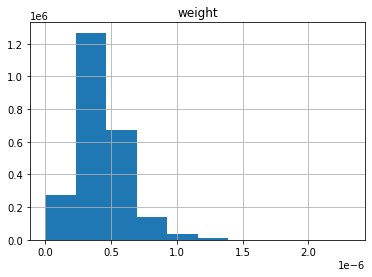

In [9]:
# посчитал веса приведя их сумму к 1
data['weight'] = data['log_sales_value']/sum(data['log_sales_value'])
display(data[['weight']].describe())

_ = data['weight'].sum()
print(f'Сумма весов: {_}')

data[['weight']].hist();

In [10]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code

    items = np.array(items_weights['item_id'])
    weight = np.array(items_weights['weight'])

    recs =  np.random.choice(items, size=n, replace=False, p = weight)    

    return recs.tolist()

In [12]:
%%time

# your_code

result['weighted_random_recommendation'] = result['user_id'].\
                                            apply(lambda x: weighted_random_recommendation(data, n=5))

CPU times: user 1min 36s, sys: 2.88 s, total: 1min 38s
Wall time: 1min 42s


In [13]:
result.head()

,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 844179, 1008673, 873203, 1053690]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[899766, 1022097, 982493, 992010, 941856]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5591627, 1109981, 998037, 10344969, 1043751]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1070820, 877611, 1022053, 1038663, 5569471]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1003188, 1026118, 941883, 820895, 1131047]"


## Задание 2. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая случаный на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

## Cлучайноый выбор на топ 5000

In [66]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()


def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)

def precision_at_k(recommended_list, bought_list, k=5):
    return precision(recommended_list[:k], bought_list)


In [19]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [20]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
top_all = popularity.sort_values('n_sold', ascending=False).item_id.tolist()

In [21]:
%%time

result['random_recommendation_top5000'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
result['random_recommendation_top_all'] = result['user_id'].apply(lambda x: random_recommendation(top_all, n=5))

CPU times: user 18.2 s, sys: 142 ms, total: 18.3 s
Wall time: 18.7 s


In [26]:
for name_col in result.columns[2:]:
  print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")

0.0186:weighted_random_recommendation
0.0066:random_recommendation_top5000
0.0005:random_recommendation_top_all


Видим что weighted_random_recommendation > random_recommendation_top5000 > random_recommendation_top_all

## Разные варианты ItemItemRecommender, выбирая число соседей 

In [28]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 6666

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [29]:
# создаем словари id_to_itemid и id_to_userid

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [67]:
%%time

k = np.arange(1, 11)
precision_ = {}

for neighbor in tqdm(k):

    precision_[str(neighbor)] = np.nan

    model = ItemItemRecommender(K=neighbor, num_threads=4) 


    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=False)


    result[f'itemitem_{i}'] = result['user_id'].apply(lambda user_id: [
                                     id_to_itemid[rec[0]]  for rec in model.recommend(userid=userid_to_id[user_id], 
                                                user_items=sparse_user_item,   # на вход user-item matrix
                                                N=5, 
                                                filter_already_liked_items=False, 
                                                filter_items=[itemid_to_id[6666]], 
                                                recalculate_user=True)])
    
    precision_[str(neighbor)] = round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

CPU times: user 24.8 s, sys: 179 ms, total: 24.9 s
Wall time: 15.9 s


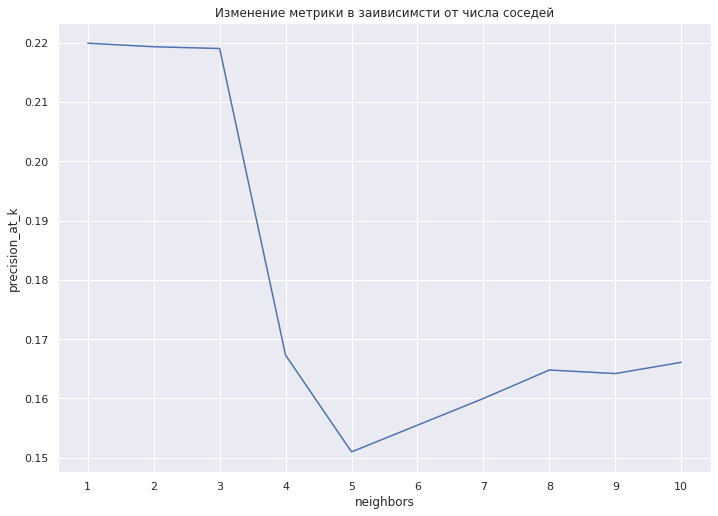

In [75]:
data = pd.DataFrame(precision_.items(), columns = ['neighbors', 'precision_at_k'])

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, x="neighbors", y="precision_at_k").set_title('Изменение метрики в заивисимсти от числа соседей');

Наверно ожидаемо получили лучшие метрики при K < 4